In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import AdamW
import numpy as np
import copy
from collections import deque
import gym
from gym.spaces import Discrete, Box
from itertools import count
import random
from gym.wrappers import NormalizeObservation, NormalizeReward
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#!pip install ipdb
#import ipdb

In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [3]:
env_name = 'LunarLanderContinuous-v2'

In [4]:
# Actor Network
class ActorNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(ActorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )
        self.mu_head = nn.Linear(int(hidden_units/2),  output_size)
        self.logstd_head = nn.Linear(int(hidden_units/2),  output_size)

    def forward(self, x):
        x = self.model(x)
        loc = torch.tanh(self.mu_head(x)) * 2
        scale = torch.exp(self.logstd_head(x))
        return loc, scale

    def __call__(self, x):
        out = self.forward(x)
        return out

In [5]:
class CriticNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(CriticNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )
        self.value_head = nn.Linear(int(hidden_units/2), 1)

    def forward(self, x):
        x = self.model(x)
        value = self.value_head(x)
        return value

    def __call__(self, x):
        out = self.forward(x)
        return out

In [6]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [7]:
nenvs=16
env = gym.vector.make(env_name, num_envs=nenvs) #, new_step_api=True
#env = NormalizeObservation(env)
#env = NormalizeReward(env)
obs_dim = env.single_observation_space.shape[0]
n_acts = env.single_action_space.shape[0]

/usr/local/lib/python3.8/dist-packages/gym/vector/vector_env.py:56: DeprecationWarning: WARN: Initializing vector env in old step API which returns one bool array instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
# Actor-Critic networks
hidden_sizes = 128
actor_net = ActorNet(obs_dim, hidden_sizes, n_acts)
actor_net = actor_net.apply(initialize_weights)

critic_net = CriticNet(obs_dim, hidden_sizes, n_acts)
critic_net = critic_net.apply(initialize_weights)

In [9]:
# optimizer
actor_optimizer = AdamW(actor_net.parameters(), lr=0.0003)
critic_optimizer = AdamW(critic_net.parameters(), lr=0.0003)

In [10]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [11]:
class RunningMem():

    def __init__(self):
        self.reset()

    def store(self, obs, action, logprob, reward, done, obs_, values, values_):
        self.obs.append(obs)
        self.actions.append(action.unsqueeze(-1))
        self.logprobs.append(logprob)
        self.rewards.append(reward.unsqueeze(-1))
        self.dones.append(done.unsqueeze(-1))
        self.obs_.append(obs_)
        self.values.append(values)
        self.values_.append(values_)


    def batches(self, batchsize):
        size = nenvs*memsteps
        idx = list(range(size))
        random.shuffle(idx)

        b_obs = torch.stack(self.obs)
        b_actions = torch.stack(self.actions)
        b_logprobs = torch.stack(self.logprobs)
        b_rewards = torch.stack(self.rewards)
        b_dones = torch.stack(self.dones)
        b_obs_ = torch.stack(self.obs_)
        b_values = torch.stack(self.values)
        b_values_ = torch.stack(self.values_)

        gaes = []
        gae = T(np.zeros(nenvs)).view(nenvs,-1)
        for i in range(len(b_obs)-1,-1,-1):
            delta = b_rewards[i] + gamma * b_values_[i] * (1-b_dones[i]) - b_values[i]
            gae = delta + gamma * lmbda * (1-b_dones[i]) * gae
            gaes.insert(0, gae)
        
        b_obs = b_obs.view(size, -1)
        b_actions = b_actions.view(size, -1)
        b_logprobs = b_logprobs.view(size, -1)
        b_rewards = b_rewards.view(size, -1)
        b_dones = b_dones.view(size, -1)
        b_obs_ = b_obs_.view(size, -1)
        b_values = b_values.view(size, -1)
        b_values_ = b_values_.view(size, -1)
        b_gae = torch.stack(gaes).view(size, -1)

        for batchn in range(0, len(idx), batchsize):
            batchidx = idx[batchn:batchn+batchsize]
            batchidx = Ti(batchidx)
            mb_obs = torch.index_select(b_obs, 0, batchidx)
            mb_actions = torch.index_select(b_actions, 0, batchidx)
            mb_logprobs = torch.index_select(b_logprobs, 0, batchidx)
            mb_rewards = torch.index_select(b_rewards, 0, batchidx)
            mb_dones = torch.index_select(b_dones, 0, batchidx)
            mb_obs_ = torch.index_select(b_obs_, 0, batchidx)
            mb_values = torch.index_select(b_values, 0, batchidx)
            mb_values_ = torch.index_select(b_values_, 0, batchidx)
            mb_gae = torch.index_select(b_gae, 0, batchidx)
            yield mb_obs, mb_actions, mb_logprobs, mb_rewards, mb_dones, mb_obs_, mb_values, mb_values_, mb_gae


    def reset(self):
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []    
        self.obs_ = []
        self.values = []
        self.values_ = []
        self.gae = []

In [12]:
@torch.no_grad()
def sim_action(policy, obs):
    loc, std = policy(T(obs))
    dist = Normal(loc=loc, scale=std+1e-6)
    action = dist.sample()
    action_log_prob = torch.sum(dist.log_prob(action), dim=-1, keepdim=True)
    return action, action_log_prob

In [13]:
def train(mem, gamma=0.99, batchsize=10, epoch_repeat=20, epsilon=0.2, lmbda=0.95):
    for epochrep in range(epoch_repeat):
        for batch in mem.batches(batchsize=batchsize):
            obs, actions, logprobs, rewards, dones, obs_, values, values_, gae = batch
            gae = (gae - torch.mean(gae)) / (torch.std(gae) + 1e-6)
            target = gae + values
            state_values = critic_net(obs)
            critic_loss = F.smooth_l1_loss(state_values, target).mean()
            
            new_loc, new_scale = actor_net(obs)
            dist = Normal(loc=new_loc, scale=new_scale+1e-6)
            new_logprobs = torch.sum(dist.log_prob(actions), dim=-1, keepdim=True)
            rho = torch.exp(new_logprobs - logprobs)
            surrgt1 = rho * gae
            surrgt2 = rho.clamp(1-epsilon, 1+epsilon) * gae
            policy_loss = -torch.minimum(surrgt1, surrgt2).mean()

            loss = policy_loss + 0.5*critic_loss
            actor_optimizer.zero_grad()
            critic_optimizer.zero_grad()
            loss.backward()
            actor_optimizer.step()
            critic_optimizer.step()


In [14]:
results_array = []
epoch_results_array = []

In [15]:
results = deque(maxlen=50)
memsteps = 500
mem = RunningMem()
gamma=0.99
lmbda=0.95
epsilon = 0.18
batchsize=80
epoch_repeat=15


totreward = np.zeros(nenvs)
stepcount = 0
epoc = 0
obs = env.reset()

while True:
    stepcount+=1
    action, action_log_prob = sim_action(actor_net, obs)
    next_obs, reward, done, _ = env.step(action.numpy())
    with torch.no_grad():
            values = critic_net(T(obs))
            values_ = critic_net(T(next_obs))    
    mem.store(T(obs), action, action_log_prob, T(reward), Ti(done), T(next_obs), values, values_)
    obs = next_obs
    totreward += reward
    doneidx = np.where(done==True)
    for k in doneidx[0]:
        results.append(totreward[k])
        totreward[k] = 0
    results_array.append(np.mean(results)) 
    if stepcount>1 and stepcount % memsteps == 0:
        epoc+=1
        epoch_results_array.append(np.mean(results))
        train(mem, gamma=gamma, batchsize=batchsize, epoch_repeat=epoch_repeat, epsilon=epsilon, lmbda=lmbda)   
        mem.reset()
        if epoc % 5 == 0:
            print(f'Epoc: {epoc} Avg Result: {np.mean(results)}')
            
    if len(results)>0 and np.mean(results) > 195:
        print(f'Solved!  Epoc: {epoc} Avg Result: {np.mean(results)}')
        break


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoc: 5 Avg Result: -121.88862870212456
Epoc: 10 Avg Result: -54.643294473040676
Epoc: 15 Avg Result: -25.27029272031074
Epoc: 20 Avg Result: -57.34353237617297
Epoc: 25 Avg Result: -64.23250449973396
Epoc: 30 Avg Result: -40.90364336542275
Epoc: 35 Avg Result: -22.46913520129469
Epoc: 40 Avg Result: -14.659889271582994
Epoc: 45 Avg Result: -1.5439337725191644
Epoc: 50 Avg Result: 0.11497304645758036
Epoc: 55 Avg Result: 13.447100534946943
Epoc: 60 Avg Result: 12.679183893694399
Epoc: 65 Avg Result: 24.81849301015914
Epoc: 70 Avg Result: 23.685514003646713
Epoc: 75 Avg Result: 41.635865168746356
Epoc: 80 Avg Result: 37.97167249686801
Epoc: 85 Avg Result: 29.111936167428865
Epoc: 90 Avg Result: 39.24339589012092
Epoc: 95 Avg Result: 53.807193460548426
Epoc: 100 Avg Result: 66.40934001027466
Epoc: 105 Avg Result: 79.48213156389825
Epoc: 110 Avg Result: 76.00603182858634
Epoc: 115 Avg Result: 89.90895574063336
Epoc: 120 Avg Result: 93.53237935194407
Epoc: 125 Avg Result: 103.8827835008810

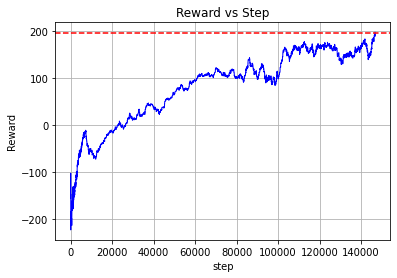

In [16]:
(fig, ax) = plt.subplots(1, 1)
# fig.set_size_inches(8, 5)
ax.set_xlabel('step')
ax.set_ylabel('Reward')
ax.set_title('Reward vs Step')
ax.plot(range(1, len(results_array) + 1), results_array, color='blue', linestyle='-', linewidth=1, label = "Reward")
ax.axhline(y = 195, color = 'r', linestyle = '--')
ax.grid()

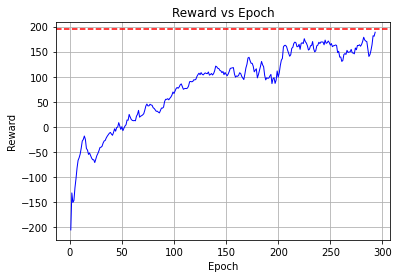

In [18]:
(fig, ax) = plt.subplots(1, 1)
# fig.set_size_inches(8, 5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Reward')
ax.set_title('Reward vs Epoch')
ax.plot(range(1, len(epoch_results_array) + 1), epoch_results_array, color='blue', linestyle='-', linewidth=1, label = "Reward")
ax.axhline(y = 195, color = 'r', linestyle = '--')
ax.grid()

In [23]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3130 sha256=8b367e2fbeb6af88ebd290ddbdcf8cc9b5dcf1b44dcfea3e28cd1817aa3b0ee0
  Stored in directory: /root/.cache/pip/wheels/e4/d2/e1/cc1c940178ad92438325422b51c3e8c3d927b9ef8381da8840
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=c3ed83af51420c50823b7a533583a922b4f03d70de4853a5f0acdfc08e34d1d4
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found exist

In [25]:
from colabgymrender.recorder import Recorder
env = gym.make("LunarLanderContinuous-v2")
env = Recorder(env, './video')

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



In [26]:

obs = env.reset()
done = False
while not done:
    with torch.no_grad():
        action, action_log_prob = sim_action(actor_net, obs)
        next_obs, reward, done, _ = env.step(action.numpy())
        obs = next_obs     
env.play()

  result = np.fromstring(s, dtype='uint8')

